<a href="https://colab.research.google.com/github/RMottram/2D-CNN/blob/master/2D_CNN_COLAB_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [1]:
!nvidia-smi

Wed Sep 15 10:51:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !unzip /content/drive/MyDrive/Colab\ Notebooks/64x64.zip > /dev/null
# !unzip /content/drive/MyDrive/Colab\ Notebooks/32x32.zip > /dev/null
!unzip /content/drive/MyDrive/Colab\ Notebooks/split_images.zip > /dev/null

In [4]:
## libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys, os, time, csv, glob, cv2, random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Convolution1D, Convolution2D, MaxPooling2D, Flatten, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn import metrics

## Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision = 5, suppress = True)

# CNN 1.0 - Binary output (attack/normal)

In [7]:
# train_normal = []
# test_normal = []
# train_smurf = []
# test_smurf = []
train_ip = []
test_ip = []
train_port = []
test_port = []
# train_nmap = []
# test_nmap = []

# for i in glob.glob('/content/split_images/32x32_V2/70-30/train_normal/train_normal_equ_*.jpg', recursive=True):
#     train_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

# for j in glob.glob('/content/split_images/32x32_V2/70-30/test_normal/test_normal_equ_*.jpg', recursive=True):
#     test_normal.append(cv2.imread(j, cv2.IMREAD_GRAYSCALE))

# for k in glob.glob('/content/split_images/32x32_V2/70-30/train_smurf/train_smurf_equ_*.jpg', recursive=True):
#     train_smurf.append(cv2.imread(k, cv2.IMREAD_GRAYSCALE))

# for l in glob.glob('/content/split_images/32x32_V2/70-30/test_smurf/test_smurf_equ_*.jpg', recursive=True):
#     test_smurf.append(cv2.imread(l, cv2.IMREAD_GRAYSCALE))

for m in random.sample(glob.glob('/content/split_images/64x64_V2/80-20/train_ip/train_ip_equ_*.jpg', recursive=True), 1780):
    train_ip.append(cv2.imread(m, cv2.IMREAD_GRAYSCALE))

for n in random.sample(glob.glob('/content/split_images/64x64_V2/80-20/test_ip/test_ip_equ_*.jpg', recursive=True), 450):
    test_ip.append(cv2.imread(n, cv2.IMREAD_GRAYSCALE))
    
for o in glob.glob('/content/split_images/64x64_V2/80-20/train_port/train_port_equ_*.jpg', recursive=True):
    train_port.append(cv2.imread(o, cv2.IMREAD_GRAYSCALE))

for p in glob.glob('/content/split_images/64x64_V2/80-20/test_port/test_port_equ_*.jpg', recursive=True):
    test_port.append(cv2.imread(p, cv2.IMREAD_GRAYSCALE))
    
# for q in glob.glob('/content/split_images/32x32_V2/70-30/train_nmap/train_nmap_equ_*.jpg', recursive=True):
#     train_nmap.append(cv2.imread(q, cv2.IMREAD_GRAYSCALE))

# for r in glob.glob('/content/split_images/32x32_V2/70-30/test_nmap/test_nmap_equ_*.jpg', recursive=True):
#     test_nmap.append(cv2.imread(r, cv2.IMREAD_GRAYSCALE))
    


# train_normal = np.array(train_normal)
# test_normal = np.array(test_normal)
# train_smurf = np.array(train_smurf)
# test_smurf = np.array(test_smurf)
train_ip = np.array(train_ip)
test_ip = np.array(test_ip)
train_port = np.array(train_port)
test_port = np.array(test_port)
# train_nmap = np.array(train_nmap)
# test_nmap = np.array(test_nmap)

In [8]:
print(f'IP train\t{np.shape(train_ip)}\nIP test\t\t{np.shape(test_ip)}')
print(f'Port train\t{np.shape(train_port)}\nPort test\t{np.shape(test_port)}')

IP train	(1780, 64, 64)
IP test		(450, 64, 64)
Port train	(1779, 64, 64)
Port test	(445, 64, 64)


In [28]:
## augmenting the data to create more images
## only run cell if needed

## vertically flip training images
# vert_flip_train_normal = np.fliplr(train_normal)
# vert_flip_train_smurf = np.fliplr(train_smurf)
vert_flip_train_ip = np.fliplr(train_ip)
vert_flip_train_port = np.fliplr(train_port)
# vert_flip_train_nmap = np.fliplr(train_nmap)

## flip training images horizonatally
# hor_flip_train_normal = np.rot90(train_normal, axes = (1,2), k = 2)
# hor_flip_train_smurf = np.rot90(train_smurf, axes = (1,2), k = 2)
hor_flip_train_ip = np.rot90(train_ip, axes = (1,2), k = 2)
hor_flip_train_port = np.rot90(train_port, axes = (1,2), k = 2)
# hor_flip_train_nmap = np.rot90(train_nmap, axes = (1,2), k = 2)

## rotate training images left and right once each
# rotate90l_train_normal = np.rot90(train_normal, axes=(1, 2))
# rotate90r_train_normal = np.rot90(train_normal, -1, axes=(1, 2))
# rotate90l_train_smurf = np.rot90(train_smurf, axes=(1, 2))
# rotate90r_train_smurf = np.rot90(train_smurf, -1, axes=(1, 2))
# rotate90l_train_ip = np.rot90(train_ip, axes=(1, 2))
# rotate90r_train_ip = np.rot90(train_ip, -1, axes=(1, 2))
# rotate90l_train_port = np.rot90(train_port, axes=(1, 2))
# rotate90r_train_port = np.rot90(train_port, -1, axes=(1, 2))
# rotate90l_train_nmap = np.rot90(train_nmap, axes=(1, 2))
# rotate90r_train_nmap = np.rot90(train_nmap, -1, axes=(1, 2))





## vertically flip testing images
# vert_flip_test_normal = np.fliplr(test_normal)
# vert_flip_test_smurf = np.fliplr(test_smurf)
vert_flip_test_ip = np.fliplr(test_ip)
vert_flip_test_port = np.fliplr(test_port)
# vert_flip_test_nmap = np.fliplr(test_nmap)

## flip testing images horizonatally
# hor_flip_test_normal = np.rot90(test_normal, axes = (1,2), k = 2)
# hor_flip_test_smurf = np.rot90(test_smurf, axes = (1,2), k = 2)
hor_flip_test_ip = np.rot90(test_ip, axes = (1,2), k = 2)
hor_flip_test_port = np.rot90(test_port, axes = (1,2), k = 2)
# hor_flip_test_nmap = np.rot90(test_nmap, axes = (1,2), k = 2)

## rotate testing images left and right once each
# rotate90l_test_normal = np.rot90(test_normal, axes=(1, 2))
# rotate90r_test_normal = np.rot90(test_normal, -1, axes=(1, 2))
# rotate90l_test_smurf = np.rot90(test_smurf, axes=(1, 2))
# rotate90r_test_smurf = np.rot90(test_smurf, -1, axes=(1, 2))
# rotate90l_test_ip = np.rot90(test_ip, axes=(1, 2))
# rotate90r_test_ip = np.rot90(test_ip, -1, axes=(1, 2))
# rotate90l_test_port = np.rot90(test_port, axes=(1, 2))
# rotate90r_test_port = np.rot90(test_port, -1, axes=(1, 2))
# rotate90l_test_nmap = np.rot90(test_nmap, axes=(1, 2))
# rotate90r_test_nmap = np.rot90(test_nmap, -1, axes=(1, 2))


## stack all the original and augmented data to one single numpy array
# train = np.vstack((train_normal, vert_flip_train_normal, hor_flip_train_normal, rotate90l_train_normal, rotate90r_train_normal, train_ip, vert_flip_train_ip, hor_flip_train_ip, rotate90l_train_ip, rotate90r_train_ip, train_port, vert_flip_train_port, hor_flip_train_port, rotate90l_train_port, rotate90r_train_port))
# test = np.vstack((test_normal, vert_flip_test_normal, hor_flip_test_normal, rotate90l_test_normal, rotate90r_test_normal, test_ip, vert_flip_test_ip, hor_flip_test_ip, rotate90l_test_ip, rotate90r_test_ip, test_port, vert_flip_test_port, hor_flip_test_port, rotate90l_test_port, rotate90r_test_port))

train = np.vstack((train_ip, vert_flip_train_ip, hor_flip_train_ip, train_port, vert_flip_train_port, hor_flip_train_port))
test = np.vstack((test_ip, vert_flip_test_ip, hor_flip_test_ip, test_port, vert_flip_test_port, hor_flip_test_port))

In [9]:
## if no augmented data is needed, run this cell
train = np.vstack((train_ip, train_port))
test = np.vstack((test_ip, test_port))

train.shape, test.shape

((3559, 64, 64), (895, 64, 64))

In [29]:
train = train.reshape(-1,64,64,1)
test = test.reshape(-1,64,64,1)

train.shape, test.shape

((10677, 64, 64, 1), (2685, 64, 64, 1))

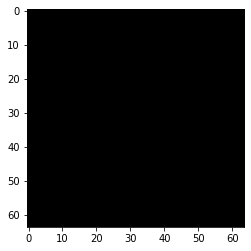

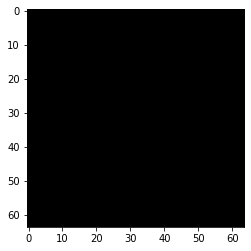

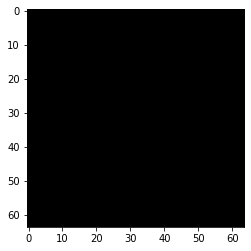

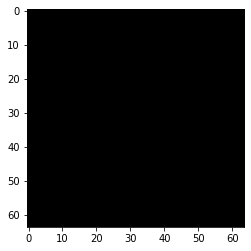

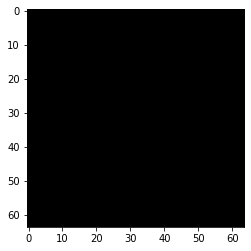

In [11]:
for i in range(0, 5):
    plt.imshow(tf.squeeze(train[i]), cmap = 'gray')
    plt.show()

In [12]:
## create the training and testing data labels
## run if not using augmented data

training_labels = []

# for i in range(0, train_normal.shape[0]):
#     training_labels.append('Normal')

# for j in range(0, train_smurf.shape[0]):
#     training_labels.append('Smurf-DDoS')
    
for k in range(0, train_ip.shape[0]):
    training_labels.append('IP-Sweep')
    
for l in range(0, train_port.shape[0]):
    training_labels.append('Port-Sweep')
    
# for m in range(0, train_nmap.shape[0]):
#     training_labels.append('Nmap-Sweep')



testing_labels = []

# for i in range(0, test_normal.shape[0]):
#     testing_labels.append('Normal')

# for j in range(0, test_smurf.shape[0]):
#     testing_labels.append('Smurf-DDoS')
    
for k in range(0, test_ip.shape[0]):
    testing_labels.append('IP-Sweep')
    
for l in range(0, test_port.shape[0]):
    testing_labels.append('Port-Sweep')
    
# for m in range(0, test_nmap.shape[0]):
#     testing_labels.append('Nmap-Sweep')

In [13]:
pd.DataFrame(training_labels)

,0
0,IP-Sweep
1,IP-Sweep
2,IP-Sweep
3,IP-Sweep
4,IP-Sweep
...,...
3554,Port-Sweep
3555,Port-Sweep
3556,Port-Sweep
3557,Port-Sweep


In [ ]:
## create the training and testing data labels
## run this cell if using augmented data with rotated data

training_labels = []

for i in range(0, train_normal.shape[0] + vert_flip_train_normal.shape[0] + hor_flip_train_normal.shape[0] + rotate90l_train_normal.shape[0] + rotate90r_train_normal.shape[0]):
    training_labels.append('Normal')

# for j in range(0, train_smurf.shape[0] + vert_flip_train_smurf.shape[0] + hor_flip_train_smurf.shape[0] + rotate90l_train_smurf.shape[0] + rotate90r_train_smurf.shape[0]):
#     training_labels.append('Smurf-DDoS')
    
for k in range(0, train_ip.shape[0] + vert_flip_train_ip.shape[0] + hor_flip_train_ip.shape[0] + rotate90l_train_ip.shape[0] + rotate90r_train_ip.shape[0]):
    training_labels.append('IP-Sweep')
    
for l in range(0, train_port.shape[0] + vert_flip_train_port.shape[0] + hor_flip_train_port.shape[0] + rotate90l_train_port.shape[0] + rotate90r_train_port.shape[0]):
    training_labels.append('Port-Sweep')
    
# for m in range(0, train_nmap.shape[0] + vert_flip_train_nmap.shape[0] + hor_flip_train_nmap.shape[0] + rotate90l_train_nmap.shape[0] + rotate90r_train_nmap.shape[0]):
#     training_labels.append('Nmap-Sweep')



testing_labels = []

for i in range(0, test_normal.shape[0] + vert_flip_test_normal.shape[0] + hor_flip_test_normal.shape[0] + rotate90l_test_normal.shape[0] + rotate90r_test_normal.shape[0]):
    testing_labels.append('Normal')

# for j in range(0, test_smurf.shape[0] + vert_flip_test_smurf.shape[0] + hor_flip_test_smurf.shape[0] + rotate90l_test_smurf.shape[0] + rotate90r_test_smurf.shape[0]):
#     testing_labels.append('Smurf-DDoS')
    
for k in range(0, test_ip.shape[0] + vert_flip_test_ip.shape[0] + hor_flip_test_ip.shape[0] + rotate90l_test_ip.shape[0] + rotate90r_test_ip.shape[0]):
    testing_labels.append('IP-Sweep')
    
for l in range(0, test_port.shape[0] + vert_flip_test_port.shape[0] + hor_flip_test_port.shape[0] + rotate90l_test_port.shape[0] + rotate90r_test_port.shape[0]):
    testing_labels.append('Port-Sweep')
    
# for m in range(0, test_nmap.shape[0] + vert_flip_test_nmap.shape[0] + hor_flip_test_nmap.shape[0] + rotate90l_test_nmap.shape[0] + rotate90r_test_nmap.shape[0]):
#     testing_labels.append('Nmap-Sweep')

In [30]:
## create the training and testing data labels
## run this cell if using augmented data and not with rotated data

training_labels = []

# for i in range(0, train_normal.shape[0] + vert_flip_train_normal.shape[0] + hor_flip_train_normal.shape[0]):
#     training_labels.append('Normal')

# for j in range(0, train_smurf.shape[0] + vert_flip_train_smurf.shape[0] + hor_flip_train_smurf.shape[0]):
#     training_labels.append('Smurf-DDoS')
    
for k in range(0, train_ip.shape[0] + vert_flip_train_ip.shape[0] + hor_flip_train_ip.shape[0]):
    training_labels.append('IP-Sweep')
    
for l in range(0, train_port.shape[0] + vert_flip_train_port.shape[0] + hor_flip_train_port.shape[0]):
    training_labels.append('Port-Sweep')
    
# for m in range(0, train_nmap.shape[0] + vert_flip_train_nmap.shape[0] + hor_flip_train_nmap.shape[0]):
#     training_labels.append('Nmap-Sweep')



testing_labels = []

# for i in range(0, test_normal.shape[0] + vert_flip_test_normal.shape[0] + hor_flip_test_normal.shape[0]):
#     testing_labels.append('Normal')

# for j in range(0, test_smurf.shape[0] + vert_flip_test_smurf.shape[0] + hor_flip_test_smurf.shape[0]):
#     testing_labels.append('Smurf-DDoS')
    
for k in range(0, test_ip.shape[0] + vert_flip_test_ip.shape[0] + hor_flip_test_ip.shape[0]):
    testing_labels.append('IP-Sweep')
    
for l in range(0, test_port.shape[0] + vert_flip_test_port.shape[0] + hor_flip_test_port.shape[0]):
    testing_labels.append('Port-Sweep')
    
# for m in range(0, test_nmap.shape[0] + vert_flip_test_nmap.shape[0] + hor_flip_test_nmap.shape[0]):
#     testing_labels.append('Nmap-Sweep')

In [31]:
## create the dataframe for labels, then OHE the column
ytrain = pd.DataFrame(training_labels, columns = ['category'])
ytest = pd.DataFrame(testing_labels, columns = ['category'])

ytrain = pd.get_dummies(ytrain['category'])
ytest = pd.get_dummies(ytest['category'])

ytrain, ytest

(       IP-Sweep  Port-Sweep
 0             1           0
 1             1           0
 2             1           0
 3             1           0
 4             1           0
 ...         ...         ...
 10672         0           1
 10673         0           1
 10674         0           1
 10675         0           1
 10676         0           1
 
 [10677 rows x 2 columns],       IP-Sweep  Port-Sweep
 0            1           0
 1            1           0
 2            1           0
 3            1           0
 4            1           0
 ...        ...         ...
 2680         0           1
 2681         0           1
 2682         0           1
 2683         0           1
 2684         0           1
 
 [2685 rows x 2 columns])

In [32]:
## shuffle the data to prevent pattern recognition
train, ytrain = sklearn.utils.shuffle(train, ytrain, random_state = 42)
test, ytest = sklearn.utils.shuffle(test, ytest, random_state = 42)

In [33]:
KERNEL_SIZE = [2,2]
IMAGE_SIZE = [64,64,1]

cnn = Sequential()

## convolution 1
cnn.add(Convolution2D(8, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 2
cnn.add(Convolution2D(16, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 3
cnn.add(Convolution2D(32, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 4
cnn.add(Convolution2D(64, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 5
# cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# # cnn.add(Dropout(0.5))

# ## convolution 6
# cnn.add(Convolution2D(256, (KERNEL_SIZE), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

cnn.add(Flatten())

## dense
# cnn.add(Dense(256, activation='relu'))
# cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(32, activation='relu'))
cnn.add(Dense(16, activation='relu'))
# cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation = 'sigmoid'))

# callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
            metrics = ['accuracy'])


cnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 64, 64, 8)         40        
_________________________________________________________________
average_pooling2d_24 (Averag (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 16)        528       
_________________________________________________________________
average_pooling2d_25 (Averag (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 32)        2080      
_________________________________________________________________
average_pooling2d_26 (Averag (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 8, 64)         

In [34]:
start = time.time()
model_history = cnn.fit(train, ytrain, batch_size = 128, epochs = 250)
end = time.time()

# os.system(f'say "training finished in {round(end - start, 2)} seconds"')
print(f'Training finished in {round(end - start, 2)}')

Epoch 1/250
84/84 [==============================] - 2s 20ms/step - loss: 0.7040 - accuracy: 0.4790
Epoch 2/250
84/84 [==============================] - 1s 17ms/step - loss: 0.6834 - accuracy: 0.5875
Epoch 3/250
84/84 [==============================] - 1s 17ms/step - loss: 0.6551 - accuracy: 0.6237
Epoch 4/250
84/84 [==============================] - 1s 16ms/step - loss: 0.6355 - accuracy: 0.6336
Epoch 5/250
84/84 [==============================] - 1s 17ms/step - loss: 0.6288 - accuracy: 0.6373
Epoch 6/250
84/84 [==============================] - 1s 16ms/step - loss: 0.6220 - accuracy: 0.6417
Epoch 7/250
84/84 [==============================] - 1s 17ms/step - loss: 0.6163 - accuracy: 0.6434
Epoch 8/250
84/84 [==============================] - 1s 17ms/step - loss: 0.6091 - accuracy: 0.6472
Epoch 9/250
84/84 [==============================] - 1s 17ms/step - loss: 0.6019 - accuracy: 0.6516
Epoch 10/250
84/84 [==============================] - 1s 16ms/step - loss: 0.5957 - accuracy: 0.6528

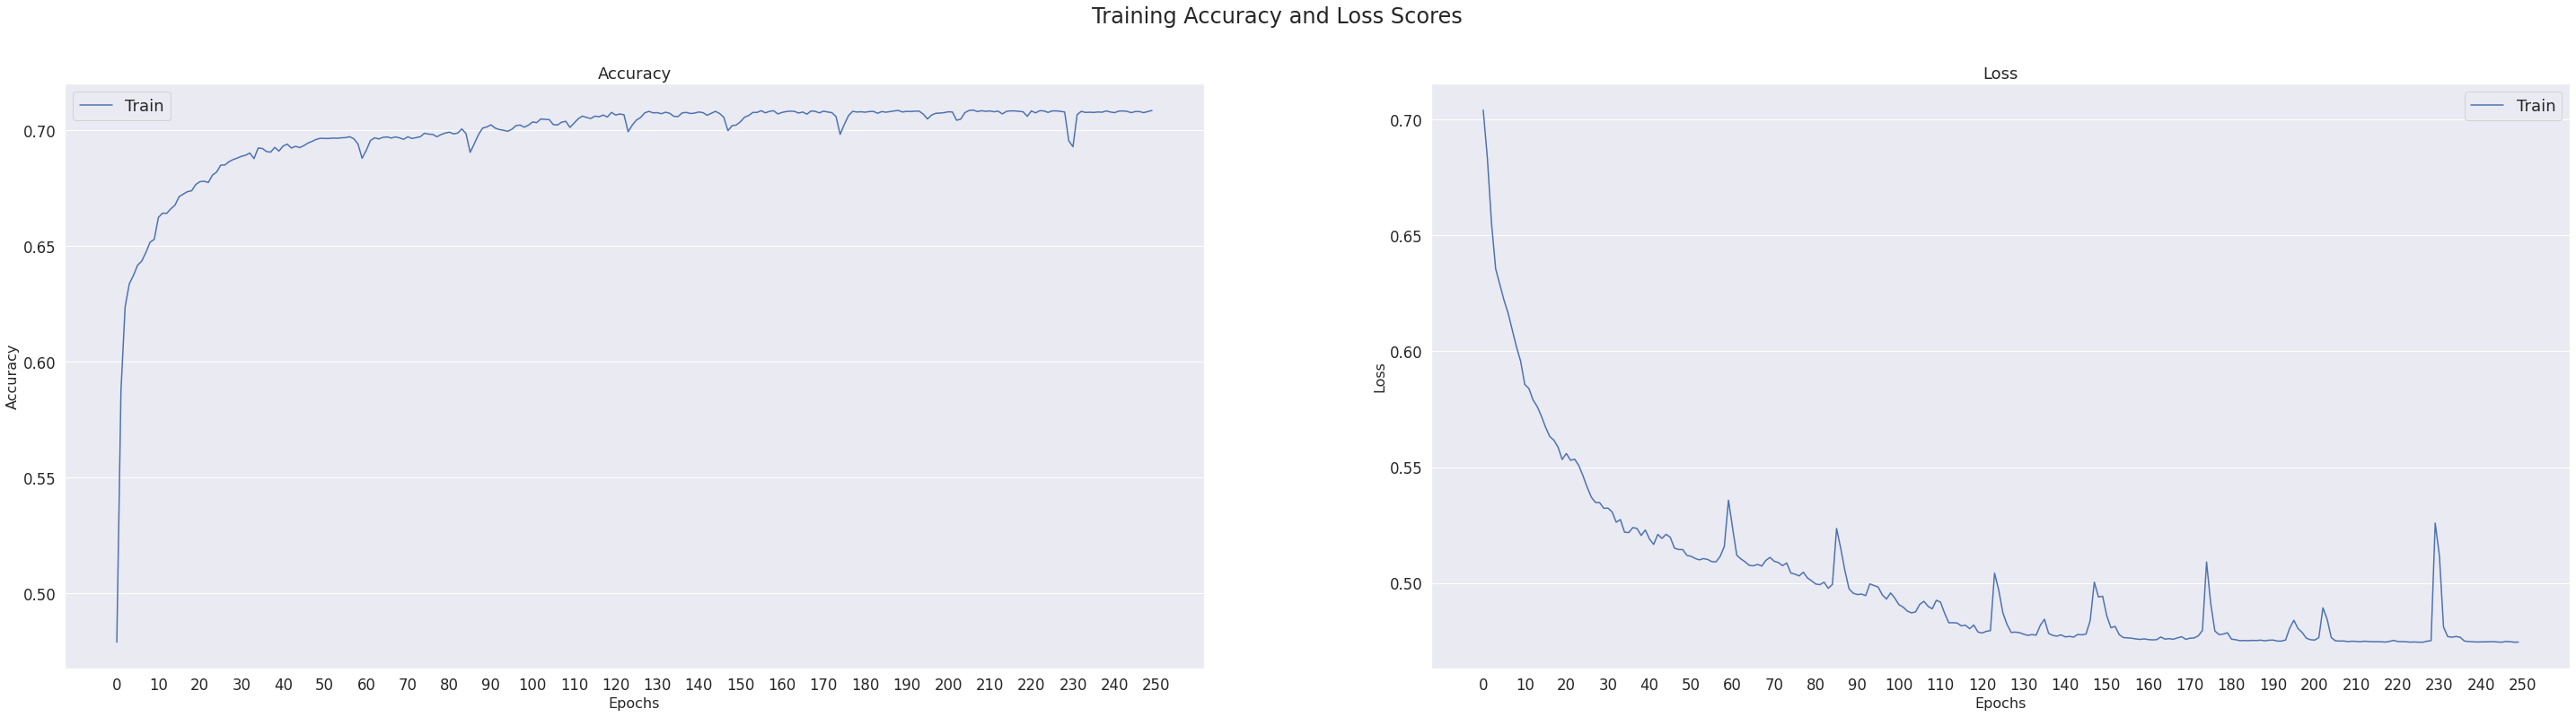

In [35]:
# print(model_history.history.keys())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50,12))
fig.suptitle('Training Accuracy and Loss Scores', fontsize = 24)

axes[0].plot(model_history.history['accuracy'])
axes[0].set_title('Accuracy', fontsize = 18)
axes[0].set_ylabel('Accuracy', fontsize = 16)
axes[0].set_xlabel('Epochs', fontsize = 16)
axes[0].set_xticks(np.arange(0, 260, step = 10))
axes[0].grid(axis = 'x')
axes[0].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

axes[1].plot(model_history.history['loss'])
axes[1].set_title('Loss', fontsize = 18)
axes[1].set_ylabel('Loss', fontsize = 16)
axes[1].set_xlabel('Epochs', fontsize = 16)
axes[1].set_xticks(np.arange(0, 260, step = 10))
axes[1].grid(axis = 'x')
axes[1].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

In [38]:
loss, acc = cnn.evaluate(test, ytest, batch_size = 128, verbose = 0)
print(f'Loss = {round(loss, 4)}\tAccuracy = {round(acc, 4)*100}%')

Loss = 1.5023	Accuracy = 62.31%


In [39]:
preds = (cnn.predict(test) > 0.5)
ypreds = np.argmax(test, axis = 1)

# label_enc = LabelEnco/transform(ytest)


# print('\tIP\tNmap\tNormal\tPort\tSmurf\n')
preds

array([[ True, False],
       [False,  True],
       [ True, False],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True],
       [ True, False],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True],
       [ True, False],
       [ True, False],
       [False,  True],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True],
       [False,  True],
       [Fal

In [40]:
def build_classifier():
    
    cnn = Sequential()

    ## convolution 1
    cnn.add(Convolution2D(8, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 2
    cnn.add(Convolution2D(16, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 3
    cnn.add(Convolution2D(32, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 4
    cnn.add(Convolution2D(64, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    ## convolution 5
    # cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
    # cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # # cnn.add(Dropout(0.5))

    # ## convolution 6
    # cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
    # cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    ## dense
    # cnn.add(Dense(256, activation='relu'))
    # cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dense(32, activation='relu'))
    cnn.add(Dense(16, activation='relu'))
    # cnn.add(Dropout(0.5))
    cnn.add(Dense(2, activation = 'sigmoid'))

    # callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

    cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
                metrics = ['accuracy'])
    
    return cnn

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 128, epochs = 250)

In [41]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, random_state = None)
score = cross_val_score(classifier, test, ytest, cv = kf)
print(f'Model Cross Validation Score - {round(score.mean(), 3)*100}%')
print(f'Model Cross Validation Scores - {score}')
print(f'Model Cross Validation standard deviation - {round(score.std(), 3)*100}')

Epoch 1/250
17/17 [==============================] - 1s 30ms/step - loss: 0.7044 - accuracy: 0.5875
Epoch 2/250
17/17 [==============================] - 0s 17ms/step - loss: 0.6721 - accuracy: 0.6206
Epoch 3/250
17/17 [==============================] - 0s 16ms/step - loss: 0.6611 - accuracy: 0.6229
Epoch 4/250
17/17 [==============================] - 0s 16ms/step - loss: 0.6447 - accuracy: 0.6294
Epoch 5/250
17/17 [==============================] - 0s 17ms/step - loss: 0.6320 - accuracy: 0.6327
Epoch 6/250
17/17 [==============================] - 0s 17ms/step - loss: 0.6257 - accuracy: 0.6378
Epoch 7/250
17/17 [==============================] - 0s 17ms/step - loss: 0.6109 - accuracy: 0.6453
Epoch 8/250
17/17 [==============================] - 0s 16ms/step - loss: 0.6010 - accuracy: 0.6494
Epoch 9/250
17/17 [==============================] - 0s 16ms/step - loss: 0.5923 - accuracy: 0.6606
Epoch 10/250
17/17 [==============================] - 0s 17ms/step - loss: 0.5912 - accuracy: 0.6560

In [42]:
targets = ['IP', 'Port']
cr = classification_report(ytest, preds, target_names=targets, zero_division=0)
cm = confusion_matrix(ytest.values.argmax(axis = 1), preds.argmax(axis = 1))

In [43]:
cm_df = pd.DataFrame(cm,
                     index = targets, 
                     columns = targets)

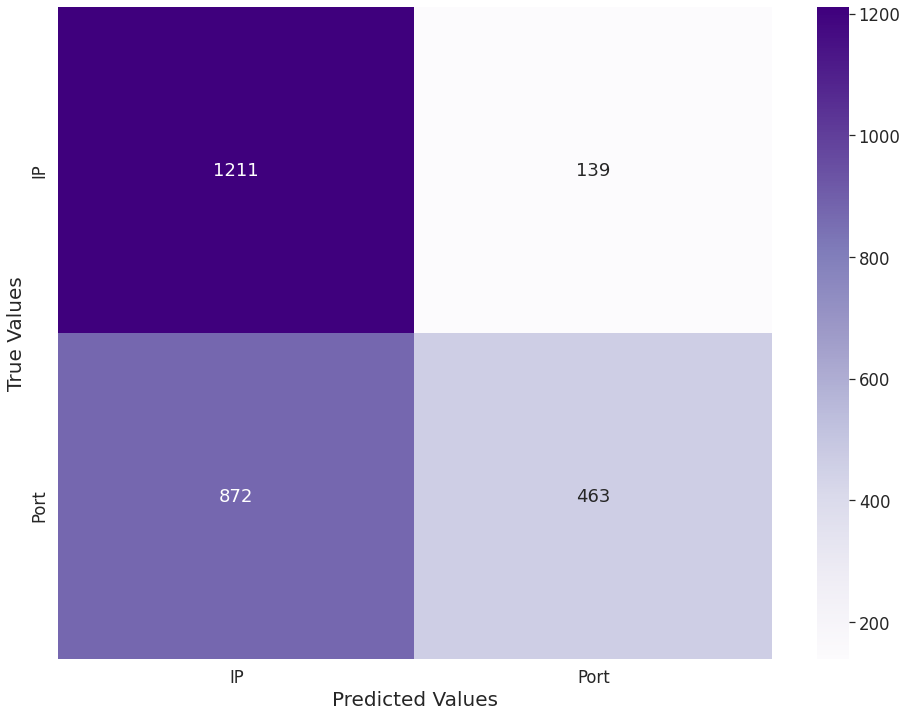

              precision    recall  f1-score   support

          IP       0.58      0.90      0.71      1350
        Port       0.77      0.35      0.48      1335

   micro avg       0.62      0.62      0.62      2685
   macro avg       0.67      0.62      0.59      2685
weighted avg       0.67      0.62      0.59      2685
 samples avg       0.62      0.62      0.62      2685



In [44]:
plt.figure(figsize=(16,12))
sns.set(font_scale=1.5)
sns.heatmap(cm_df, annot=True, cmap = 'Purples', fmt='1')
plt.ylabel('True Values', fontsize = '20')
plt.xlabel('Predicted Values', fontsize = '20')
plt.show()

print(cr)

In [45]:
def perf_measure(y_actual, y_pred, labels):
    labels = targets
    class_id = set(y_actual).union(set(y_pred))
    TP = []
    FP = []
    TN = []
    FN = []

    for index ,_id in enumerate(class_id):
        TP.append(0)
        FP.append(0)
        TN.append(0)
        FN.append(0)
        for i in range(len(y_pred)):
            if y_actual[i] == y_pred[i] == _id:
                TP[index] += 1
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1
            if y_pred[i] != _id and y_actual[i] != y_pred[i]:
                FN[index] += 1


    return(print(f'{labels}\nTP - {TP}\nFP - {FP}\nTN - {TN}\nFN - {FN}'))

In [46]:
perf_measure(ytest.values.argmax(axis = 1), preds.argmax(axis = 1), targets)

['IP', 'Port']
TP - [1211, 463]
FP - [872, 139]
TN - [463, 1211]
FN - [139, 872]
